# Trees

Trees can be used to display hierarchies or subdivisions. This includes not only clustering, but also Natural Language Processing tasks, like chunking.

In [1]:
from matplotlib.lines import Line2D

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import nltk
import os
import sys

In [2]:
document = "Anthony Lopes is a Portuguese professional footballer \
who plays for French club Olympique Lyonnais as a goalkeeper."

sentences = nltk.sent_tokenize(document)
sentences = [ nltk.word_tokenize(sentence) for sentence in sentences ]
sentences = [ nltk.pos_tag(sentence) for sentence in sentences ]
grammar = '\n'.join([
    "NE: {<NNP|FW>+}", # named entities are a string of proper nouns and possibly foreign words
    "NP: {<DT>?<JJ>*<NN|NE>+}",
    "VP: {<VB.><IN>?}"
])

cp = nltk.RegexpParser(grammar)
result = cp.parse(sentences[0])
result.pprint()
# result.draw()

(S
  (NP (NE Anthony/NNP Lopes/NNP))
  (VP is/VBZ)
  (NP a/DT Portuguese/JJ professional/JJ footballer/NN)
  who/WP
  (VP plays/VBZ for/IN)
  (NP French/JJ club/NN (NE Olympique/NNP Lyonnais/NNP))
  as/IN
  (NP a/DT goalkeeper/NN)
  ./.)


In [3]:
def get_leaves(tree):
    """
    Get the leaves of the given tree.
    
    The leaves are ordered from left to right.
    
    :param tree: The tree whose leaves will be returned.
    :type tree: :class:`nltk.tree.Tree`
    
    :return: The leaves as a list.
             Each element is a tuple made up of the text and the POS tag.
    :rtype: list of tuples
    """
    
    leaves = []
    for child in tree:
        if type(child) == nltk.tree.Tree:
            leaves.extend(get_leaves(child))
        else:
            leaves.append(child)
    
    return leaves

def get_depth(tree):
    """
    Get the depth of the given tree.
    The depth is the longest path from the root node to a leave node.
    
    :param tree: The tree whose depth will be returned.
    :type tree: :class:`nltk.tree.Tree`
    
    :return: The depth of the tree.
    :rtype: int
    """
    
    depth = 0
    for child in tree:
        if type(child) == nltk.tree.Tree:
            depth = max(depth, get_depth(child) + 1)
        else:
            depth = max(depth, 1)
    return depth

def split_leaves(tree):
    """
    Split the leaves in the given tree so that the leaves are only labels.
    Their parents are their POS tags.
    The rest of the tree is unchanged.
    
    :param tree: The tree whose leaves will be split.
    :type tree: :class:`nltk.tree.Tree`
    
    :return: The new tree with split leaves.
    :rtype: :class:`nltk.tree.Tree`
    """
    
    for i, child in enumerate(tree):
        if type(child) == nltk.tree.Tree:
            tree[i] = split_leaves(child)
        else:
            tree[i] = nltk.tree.Tree(child[1], [ child[0] ])
    
    return tree

def draw_node(x, y, label):
    """
    Draw a node with the given label at the given position.
    
    :param x: The x-position of the node.
    :type x: float
    :param y: The y-position of the node.
    :type y: float
    :param label: The node's label.
    :type label: str
    
    :return: The drawn node.
    :rtype: :class:`matplotlib.text.Text`
    """
    
    text = plt.text(x, y, label, fontweight=600)
        
    return text

def get_bb(node):
    """
    Get the bounding box of the given text node.
    
    :param node: The text whose bounding box will be fetched.
    :type node: :class:`nltk.text.Text`
    
    :return: The bounding box of the text object.
    :rtype: :class:`matplotlib.transforms.Bbox`
    """
    
    renderer = figure.canvas.get_renderer()
    bb = node.get_window_extent(renderer).inverse_transformed(plt.gca().transData)
    return bb

def get_position(node, children):
    """
    Get the position of the node.
    This position is in the middle among its children.
    
    If there are an even number of nodes, then the middle is between the two middle nodes.
    If there are an odd number of nodes, then the middle is directly above the middle node.
    
    :param node: The node to be positioned.
                 This node is used to get its dimensions.
                 Thus, the node can be centered properly based on its size.
    :type node: :class:`matplotlib.text.Text`
    :param children: A list of child nodes.
    :type children: list of :class:`matplotlib.text.Text`
    
    :return: The x position.
    :rtype: float
    """
    
    if not len(children) % 2:
        """
        If there are an even number of children, this node should be between the middle ones.
        Here, the middle is calculated as the center of the town nodes' centers.
        """
        middle_bb_1 = get_bb(children[(int(len(children)/2) - 1)])
        middle_bb_2 = get_bb(children[(int(len(children)/2) - 1) + 1])
        position = (((middle_bb_2.x0 + middle_bb_2.width / 2) + 
                     (middle_bb_1.x0 + middle_bb_1.width / 2)) / 2 -
                    get_bb(node).width / 2)
    else:
        """
        Otherwise, this node should be directly above the middle child.
        """
        middle_node_bb = get_bb(children[int((len(children)/2))])
        position = (middle_node_bb.x0 + middle_node_bb.x1) / 2 - get_bb(node).width / 2
    return position
 
def connect_nodes(node, children, stub=0.4):
    """
    Connect the given node with its children.
    
    :param node: The node to be positioned.
                 This node is used to get its dimensions.
                 Thus, the node can be centered properly based on its size.
    :type node: :class:`matplotlib.text.Text`
    :param children: A list of child nodes.
    :type children: list of :class:`matplotlib.text.Text`
    :param stub: The length of the vertical line.
    :type stub: float
    """
    
    """
    First, draw a short vertical line from the node.
    """
    node_bb = get_bb(node)
    plt.plot([ node_bb.x0 + node_bb.width / 2 ] * 2, # a vertical line has the same x-coordinate
             [ node_bb.y0 - stub / 2, node_bb.y0 - stub ],
             color='C3')
    
    """
    Then, draw a horizontal line that spans all children and that touches this vertical line.
    """
    range_bb = [
        get_bb(children[0]),
        get_bb(children[-1]),
    ]
    plt.plot([ range_bb[0].x0 + range_bb[0].width / 2, range_bb[-1].x0 + range_bb[-1].width / 2 ],
             [ node_bb.y0 - stub ] * 2,
             color='C3')
    
    """
    Finally, draw the vertical lines from the horizontal line to the children.
    """
    for child in children:
        child_bb = get_bb(child)
        plt.plot([ child_bb.x0 + child_bb.width / 2 ] * 2,
                 [ child_bb.y1 + stub / 2, node_bb.y0 - stub ],
                 color='C3')

def draw_tree(tree):
    """
    Draw the given tree.
    
    :param tree: The tree that will be drawn.
    :type tree: :class:`nltk.tree.Tree`
    """
        
    depth = get_depth(tree)
    draw_subtree(tree, level=depth)

def draw_subtree(tree, level, pad=2, offset=0.1):
    """
    Draw the given tree.
    
    :param tree: The tree that will be drawn.
    :type tree: :class:`nltk.tree.Tree`
    :param pad: The padding between leaves.
    :type pad: float
    :param offset: The offset for the next leaf.
    :type offset: float
    
    :return: A tuple containing the subtree's node and the offset of the next leaf.
    :rtype: tuple
    """
    
    children = []
    
    for child in tree:
        if type(child) == nltk.tree.Tree:
            (node, offset) = draw_subtree(child, level=level-1, pad=pad, offset=offset)
            children.append(node)
        else:
            if type(child) == tuple:
                label = '/'.join(child)
            else:
                label = child
            
            node = draw_node(offset, 0, label)
            children.append(node)
            
            """
            Subsequent text components will be offset.
            """
            offset = offset + get_bb(node).width + pad
    
    node = draw_node(0, level, tree.label())
    node.set_position((get_position(node, children), get_bb(node).y0))
    connect_nodes(node, children)
    return (node, offset)

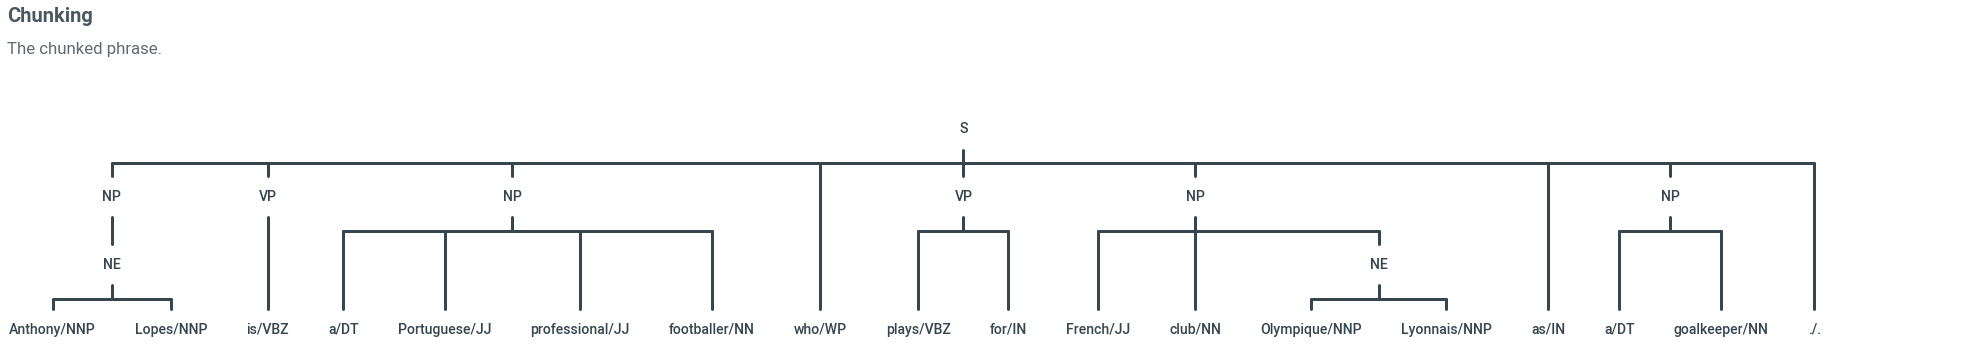

In [4]:
tree = result.copy(deep=True)
# tree = split_leaves(tree)

plt.style.use(os.path.join(sys.path[0], "fire.style"))
plt.style.reload_library()

figure = plt.figure(figsize=(35,5))

depth = get_depth(tree)
plt.xlim(0, 100)
plt.ylim(0, depth + 1)
# plt.gca().invert_yaxis() # invert the y-axis

draw_tree(tree)

plt.axis('off')
plt.title('Chunking', loc='left', fontweight='bold', alpha=0.9,
          pad=40) # pad to make space for a subtitle
ax = plt.gca()
plt.text(0, 1.02, 'The chunked phrase.',
         fontsize='large', alpha=0.8,
         horizontalalignment='left', verticalalignment='bottom',
         transform=ax.transAxes)
plt.show()